<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Inspect-data" data-toc-modified-id="Inspect-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Inspect data</a></span></li><li><span><a href="#Create-dls" data-toc-modified-id="Create-dls-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create dls</a></span><ul class="toc-item"><li><span><a href="#Review-of-ds-and-dls" data-toc-modified-id="Review-of-ds-and-dls-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Review of <code>ds</code> and <code>dls</code></a></span></li><li><span><a href="#Review-of-DataBlock" data-toc-modified-id="Review-of-DataBlock-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Review of <code>DataBlock</code></a></span></li></ul></li><li><span><a href="#Loss-fxn:-BCE" data-toc-modified-id="Loss-fxn:-BCE-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Loss fxn: BCE</a></span></li><li><span><a href="#Image-Regression-w/-Biwi-Head-Poses" data-toc-modified-id="Image-Regression-w/-Biwi-Head-Poses-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Image Regression w/ Biwi Head Poses</a></span></li><li><span><a href="#dls" data-toc-modified-id="dls-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>dls</a></span><ul class="toc-item"><li><span><a href="#learner" data-toc-modified-id="learner-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>learner</a></span></li></ul></li></ul></div>

# Inspect data

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.PASCAL_2007)

Unlike other computer vision datasets, Pascal uses a csv to assign labels. We can see below that the labels come in the form of a space-delimited string.

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


# Create dls

## Review of `ds` and `dls`

Review:
- A `Dataset` is an abstract idea of a class that you can index into with `ds[i]` and you can take the length of it (normally, indexing into it returns a tuple of `(ind, dep)` vars)
- Once we have a dataset, we can pass it to a dataloader
- A `DataLoader` is an iterator that provides a stream of minibatches

In [ ]:
ds = list(enumerate(string.ascii_lowercase))
ds[3], len(ds) # ← we can index into ds & we can get its len ∴ it's a dataset

((3, 'd'), 26)

In [ ]:
dlx = DataLoader(ds, batch_size=8, shuffle=True)
batchx = first(dlx)
batchx

(tensor([15,  3, 10, 12, 17,  5,  0, 18]),
 ('p', 'd', 'k', 'm', 'r', 'f', 'a', 's'))

Here's how to transpose the batch back into tuples:

In [ ]:
list(zip(*batchx))

[(tensor(15), 'p'),
 (tensor(3), 'd'),
 (tensor(10), 'k'),
 (tensor(12), 'm'),
 (tensor(17), 'r'),
 (tensor(5), 'f'),
 (tensor(0), 'a'),
 (tensor(18), 's')]

Because we have multiple datasets – training, validating, testing, and possibly more – we have two more classes that represent multiple datasets or multiple dataloaders:
- A `Datasets` object contains multiple datasets
- A `DataLoaders` object contains multiple dataloaders

The usual pattern in fastai is to take the raw data and to pass it through two functions: one to turn it into the dep var, and another to turn it into the indep var.

In [ ]:
raw = list(string.ascii_lowercase)
dss = Datasets(raw,) # starting here to show the pattern
dss[0]

('a',)

In [ ]:
def f1(o): return o+'-foo'
def f2(o): return o+'-bar'

In [ ]:
dss = Datasets(raw, [f1]) # transformed a; almost there...
dss[0]

('a-foo',)

In [ ]:
dss = Datasets(raw, [[f1],[f2]]) # there we go!
dss[0]

('a-foo', 'a-bar')

In [ ]:
dls = DataLoaders.from_dsets(dss, batch_size=4)
first(dls.train)

(('v-foo', 'w-foo', 'i-foo', 'm-foo'), ('v-bar', 'w-bar', 'i-bar', 'm-bar'))

There we have it – we took some raw data and passed it through a function to create the dep var, and through another to create the indep var. Ex, the raw data is often filenames, and the indep var function creates the image, and the dep var function creates the labels.

## Review of `DataBlock`

A datablock has to do all of the above. Let's build up the datablock piece by piece.

Simplest case: no parameters.

In [ ]:
db = DataBlock()

In [ ]:
dss = db.datasets(df)
len(dss.train), len(dss.valid)

(4009, 1002)

The datablock split the dataset (a df) into train and valid datasets using the default 80/20 split.

In [ ]:
x,y = dss.train[0]
x,y

(fname       006443.jpg
 labels       aeroplane
 is_valid          True
 Name: 3245, dtype: object,
 fname       006443.jpg
 labels       aeroplane
 is_valid          True
 Name: 3245, dtype: object)

Notice that by default the raw data is repeated twice. This is why when we pass a fxn, each side gets transformed by the function independently.

In [ ]:
def get_fn(df): return df['fname']
def get_lbl(df): return df['labels']

In [ ]:
db = DataBlock(get_x=get_fn, get_y=get_lbl)
dss = db.datasets(df)
dss.train[0]

('001797.jpg', 'sofa person')

Here's the same thing, but this now includes full paths which are required for finding and opening each im.

In [ ]:
list(path.ls()) # looking for dir containing ims

[Path('/home/rory/.fastai/data/pascal_2007/valid.json'),
 Path('/home/rory/.fastai/data/pascal_2007/tps1_40step.npy'),
 Path('/home/rory/.fastai/data/pascal_2007/train.csv'),
 Path('/home/rory/.fastai/data/pascal_2007/test.csv'),
 Path('/home/rory/.fastai/data/pascal_2007/segmentation'),
 Path('/home/rory/.fastai/data/pascal_2007/test.json'),
 Path('/home/rory/.fastai/data/pascal_2007/train'),
 Path('/home/rory/.fastai/data/pascal_2007/test'),
 Path('/home/rory/.fastai/data/pascal_2007/train.json')]

In [ ]:
def get_fns(df): return path/'train'/df['fname']
def get_lbls(df): return df['labels'].split(' ') # split str into list

In [ ]:
db = DataBlock(get_x=get_fns, get_y=get_lbls) # all this is the exact same
dss = db.datasets(df)
dss.train[0]

(Path('/home/rory/.fastai/data/pascal_2007/train/002702.jpg'), ['chair'])

Let's add in transform blocks. ImageBlock turns paths into PILImages, and MultiCategoryBlock one-hot-encodes labels.

In [ ]:
db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
               get_x = get_fns,
               get_y = get_lbls)
dss = db.datasets(df)
dss.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
         0., 0.]))

Side note: we store the 1he data as floats b/c we want to do cross entropy loss, which wants floats. Storing them as floats here speeds that up.

The next iteration of the dblocks build adds in a splitter to split the data by the is_valid field in the df.

In [ ]:
def split_by_col(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid

In [ ]:
db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
               get_x = get_fns,
               get_y = get_lbls,
               splitter=split_by_col)
dss = db.datasets(df)
dss.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

Last thing we'll do is add in some data augmentation.

In [ ]:
db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
               get_x = get_fns,
               get_y = get_lbls,
               splitter = split_by_col,
               item_tfms = RandomResizedCrop(128, min_scale=0.35))
dss = db.datasets(df)
dss.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

Since this is the final db, we'll use it to create the dls.

In [ ]:
dls = db.dataloaders(df)

And now we'll view a few ims+lbls from the `dss` we created with the final `db` by calling `dls.show_batch()`:

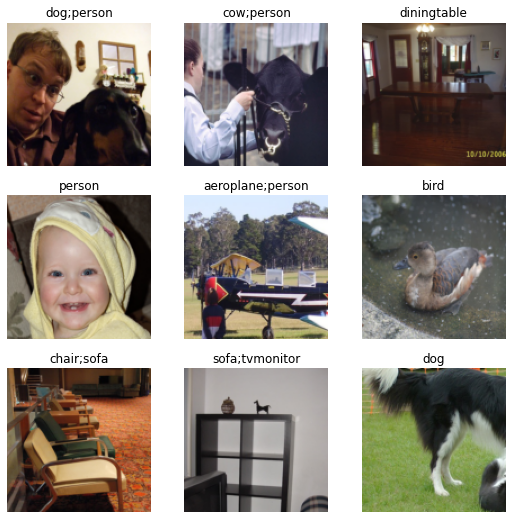

In [ ]:
dls.show_batch()

# Loss fxn: BCE

In order to create our loss function, we need to look at the activations from the model and figure out how to make sense of them. We'll start by creating our learner using resnet.

In [ ]:
learn = cnn_learner(dls, resnet18)

Let's grab a mini-batch and pass it through the learner's model.

In [ ]:
x,y = dls.train.one_batch()
acts = learn.model(x.cpu())
acts.shape # bs, len(vocab)

torch.Size([64, 20])

In [ ]:
acts[0]

TensorImage([-0.5050,  0.3596, -1.0297,  2.6051,  2.7613,  1.3641, -1.0357, -0.6067,
         0.0802,  0.1146, -2.1422, -2.2368,  0.8119,  1.8585,  0.8727, -0.7858,
         0.4685,  0.6949,  1.2260,  0.2551], grad_fn=<AliasBackward>)

These aren't between 0 and 1. Let's scale them between 0 and 1 so we can interpret these as (basically) probabilities.

In [ ]:
def bce(inputs, targs):
    inputs = inputs.sigmoid()
    return torch.where(targets==1, 1-inputs, inputs).log().mean()
    # look at mnist discussion and softmax discussion for more deets on this fxn

Note that the loss function works on a mini-batch of data – a matrix. That means that it's doing the loss function for each row in the matrix.

The metric used is accuracy_multi with a threshhold of .20.

We're ready to init and train the learner.

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.927381,0.700550,0.230757,00:06
1,0.815533,0.569036,0.287171,00:05
2,0.600032,0.203361,0.817271,00:05
3,0.358348,0.126851,0.942470,00:05


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.132368,0.117435,0.943307,00:07
1,0.117643,0.108994,0.945976,00:06
2,0.097154,0.103878,0.953028,00:06


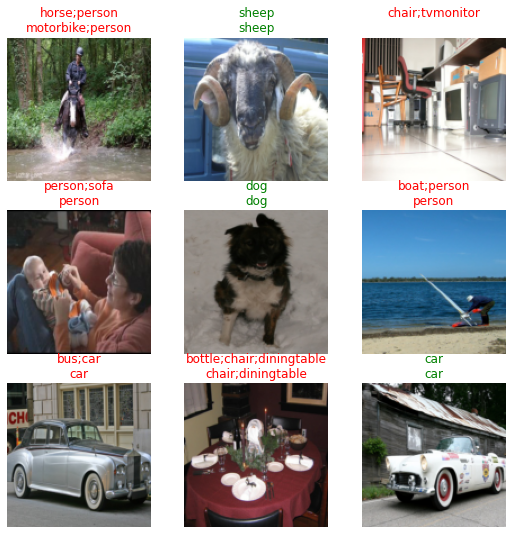

In [ ]:
learn.show_results()

This is how we pick the correct threshold for accuracy_multi:

In [ ]:
yp,y = learn.get_preds()

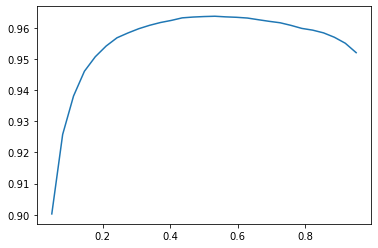

In [ ]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(yp, y, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

We're done. The best threshold is around .5, but we don't need to retrain the learner. For inference, however, this info is critical for the best interpretation of results.

# Image Regression w/ Biwi Head Poses

# dls

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [ ]:
path.ls().sorted()

(#50) [Path('/home/rory/.fastai/data/biwi_head_pose/01'),Path('/home/rory/.fastai/data/biwi_head_pose/01.obj'),Path('/home/rory/.fastai/data/biwi_head_pose/02'),Path('/home/rory/.fastai/data/biwi_head_pose/02.obj'),Path('/home/rory/.fastai/data/biwi_head_pose/03'),Path('/home/rory/.fastai/data/biwi_head_pose/03.obj'),Path('/home/rory/.fastai/data/biwi_head_pose/04'),Path('/home/rory/.fastai/data/biwi_head_pose/04.obj'),Path('/home/rory/.fastai/data/biwi_head_pose/05'),Path('/home/rory/.fastai/data/biwi_head_pose/05.obj')...]

In [ ]:
(path/'01').ls().sorted()

(#1000) [Path('/home/rory/.fastai/data/biwi_head_pose/01/depth.cal'),Path('/home/rory/.fastai/data/biwi_head_pose/01/frame_00003_pose.txt'),Path('/home/rory/.fastai/data/biwi_head_pose/01/frame_00003_rgb.jpg'),Path('/home/rory/.fastai/data/biwi_head_pose/01/frame_00004_pose.txt'),Path('/home/rory/.fastai/data/biwi_head_pose/01/frame_00004_rgb.jpg'),Path('/home/rory/.fastai/data/biwi_head_pose/01/frame_00005_pose.txt'),Path('/home/rory/.fastai/data/biwi_head_pose/01/frame_00005_rgb.jpg'),Path('/home/rory/.fastai/data/biwi_head_pose/01/frame_00006_pose.txt'),Path('/home/rory/.fastai/data/biwi_head_pose/01/frame_00006_rgb.jpg'),Path('/home/rory/.fastai/data/biwi_head_pose/01/frame_00007_pose.txt')...]

In [ ]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('/home/rory/.fastai/data/biwi_head_pose/14/frame_00323_pose.txt')

In [ ]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

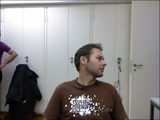

In [ ]:
im.to_thumb(160)

In [ ]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [ ]:
get_ctr(img_files[0])

tensor([397.3540, 248.6323])

In [ ]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda p: p.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)),
                Normalize.from_stats(*imagenet_stats)])

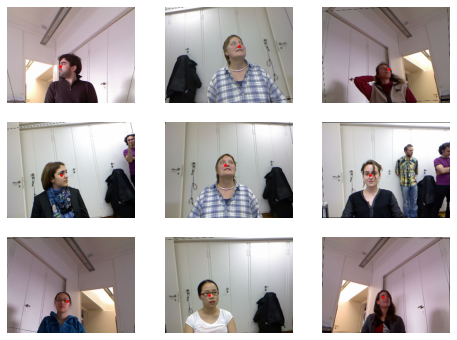

In [ ]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [ ]:
x,y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [ ]:
y[0]

TensorPoint([[ 0.0087, -0.2069]], device='cuda:0')

## learner

In [ ]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1)) # y_range adds a sigmoid

In [ ]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.03981071710586548)

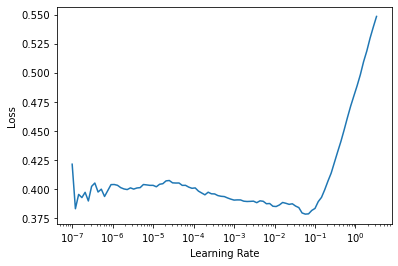

In [ ]:
learn.lr_find()

In [ ]:
lr = 1e-2
learn.fine_tune(3,lr)

epoch,train_loss,valid_loss,time
0,0.046646,0.019043,00:31


epoch,train_loss,valid_loss,time
0,0.008096,0.002814,00:39
1,0.002908,0.000298,00:39
2,0.001475,0.000129,00:39


In [ ]:
math.sqrt(0.000129)

0.011357816691600547

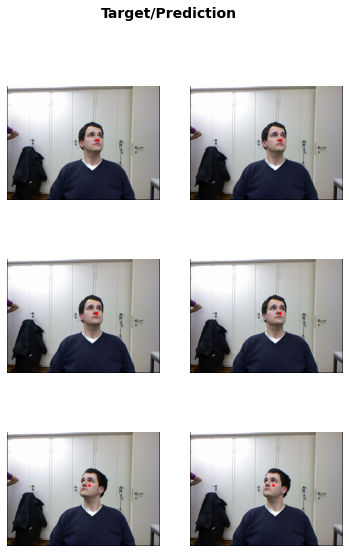

In [ ]:
learn.show_results()